In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time 
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [4]:
model_name = "openai-community/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

2025-08-05 19:30:07.095859: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 19:30:07.260253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754436607.319083  500495 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754436607.335886  500495 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754436607.472145  500495 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [6]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}

In [8]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
# batch size, sequence length, vocabulary size (number of possible tokens that would be generated in the output)
print(logits.shape)

torch.Size([1, 7, 50257])


In [9]:
last_logits = logits[0, -1, :] # last logit (-1) of the first row (0) for inference, and entire vocab (:)
next_token_id = last_logits.argmax() # What is the max value in that index
next_token_id 

tensor(13990)

In [11]:
# Decode token to text
tokenizer.decode(next_token_id)

' fence'

In [ ]:
top_k = torch.topk(last_logits, k=10) # top ten possible next tokens
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

[' fence',
 ' edge',
 ' railing',
 ' wall',
 ' table',
 ' tree',
 ' top',
 ' counter',
 ' ground',
 ' side']

In [21]:
# Adding a generated token to the inputs to generate the next token
next_inputs = {
    "input_ids":torch.cat(
        [inputs["input_ids"], next_token_id.reshape((1, 1))],
        dim=1
    ),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]])],
        dim=1
    ),
}

In [19]:
next_inputs

{'input_ids': tensor([[  464,  2068,  7586, 21831, 11687,   625,   262, 13990]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [20]:
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id


In [ ]:
generated_tokens = []
next_inputs = inputs 
durations_s = [] 

for _ in range(10):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s += [time.time() - t0]

    next_inputs = {
        "input_ids":torch.cat(
            [next_inputs["input_ids"], next_token_id.reshape((1, 1))],
            dim=1
        ),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1
        ),
    }

    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_s)} seconds")
print(generated_tokens)

0.3643531799316406 seconds
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


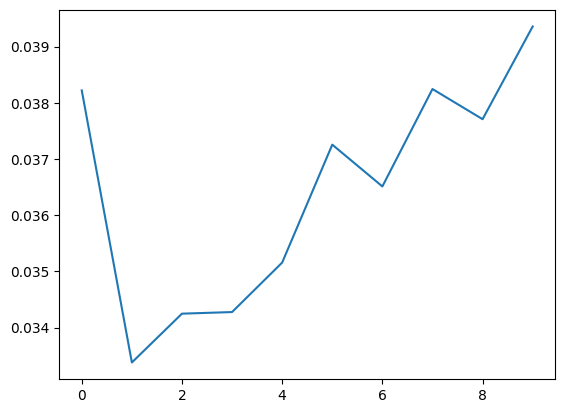

In [29]:
plt.plot(durations_s)
plt.show()

## Optimizing Token Generation

In [ ]:
# This will generate the past key values

def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

In [32]:
# The only difference is that the past key values are 

generated_tokens = []
next_inputs = inputs
durations_cached_s = []
for _ in range(10):
    t0 = time.time()
    next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]
    
    
    next_inputs = {
        "input_ids": next_token_id.reshape((1, 1)), # Rather than all the inputs, only the next input is passed
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
        "past_key_values": past_key_values, # The past key values are not recomputed, only passed in
    }
    
    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_s)} s")
print(generated_tokens)

0.359877347946167 s
[' fence', ' and', ' ran', ' to', ' the', ' other', ' side', ' of', ' the', ' fence']


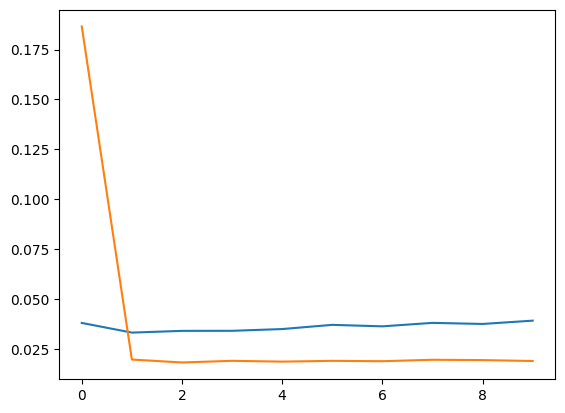

In [35]:
# Orange: the time to generate a new token is reduced because the key-values of all the previous tokens are cached and not recomputed.
plt.plot(durations_s)
plt.plot(durations_cached_s)
plt.show()

# Batching

In [1]:
# Handling More Requests: Throughput
# Handling a single request quickly: Latency

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm


/home/linux-pc/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model_name = "openai-community/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

2025-08-05 21:12:25.336093: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 21:12:25.493471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754442745.556184    8099 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754442745.573362    8099 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754442745.705476    8099 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Optimizing multiple inputs

In [5]:
# The same prompts:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")


def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values


def generate(inputs, max_tokens):
    generated_tokens = []
    next_inputs = inputs
    for _ in range(max_tokens):
        next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_id.reshape((1, 1)),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]])],
                dim=1
            ),
            "past_key_values": past_key_values,
        }

        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return "".join(generated_tokens)


tokens = generate(inputs, max_tokens=10)
print(tokens)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.53.0. You should pass an instance of `Cache` instead, e.g. `past_key_values=DynamicCache.from_legacy_cache(past_key_values)`.


 fence and ran to the other side of the fence


In [13]:
# Defining the padding token (all prompts are the same length)
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

In [14]:
# tokens are padded on the left so new tokens are appended to the right:
# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [15]:
# Sending multiple prompts simultaneously:
# multiple prompts of varying lengths to send
# to the model at once
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

# note: padding=True ensures the padding token
# will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")

In [18]:
# This shows the padding tokens
print("input_ids:", inputs["input_ids"])
print("shape:", inputs["input_ids"].shape)

input_ids: tensor([[  464,  2068,  7586, 21831, 11687,   625,   262],
        [50256, 50256,   464,  6290,   287,  8602,  8953],
        [50256, 50256, 50256,  2061,  2058,   510,  1276]])
shape: torch.Size([3, 7])


In [19]:
# The padding tokens are not attended to with a value of 0
print("attention_mask:", inputs["attention_mask"])
print("shape:", inputs["attention_mask"].shape)

attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])
shape: torch.Size([3, 7])


In [20]:
# position_ids tell the transformer the ordinal position
# of each token in the input sequence
# for single input inference, this is just [0 .. n]
# for n tokens, but for batch inference,
# we need to 0 out the padding tokens at the start of the sequence
attention_mask = inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids.masked_fill_(attention_mask == 0, 1)

tensor([[0, 1, 2, 3, 4, 5, 6],
        [1, 1, 0, 1, 2, 3, 4],
        [1, 1, 1, 0, 1, 2, 3]])

In [21]:
# same as before, but include the position_ids
with torch.no_grad():
    outputs = model(position_ids=position_ids, **inputs)
logits = outputs.logits

In [ ]:
# Retrieve the most likely token for each prompt
last_logits = logits[:, -1, :] 
next_token_ids = last_logits.argmax(dim=1) 

In [23]:
print(next_token_ids)

tensor([13990,   319,   307])


In [25]:
""" Original prompts
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]
"""
next_tokens = tokenizer.batch_decode(next_token_ids)
next_tokens

[' fence', ' on', ' be']

In [27]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values

In [28]:
def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = \
            generate_batch_tokens_with_past(next_inputs)

        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1)),  
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

In [29]:
generated_tokens = generate_batch(inputs, max_tokens=10)

In [30]:
for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

The quick brown fox jumped over the  fence and ran to the other side of the fence

The rain in Spain falls  on the first day of the month, and the

What comes up must  be a good idea.

"I think



In [31]:
# constants
max_tokens = 10

# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(8)]
for batch_size in batch_sizes:
    print(f"bs= {batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompts = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]
    inputs = tokenizer(
        batch_prompts, padding=True, return_tensors="pt"
    )
    generated_tokens = generate_batch(inputs, max_tokens=max_tokens)
    duration_s = time.time() - t0

    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print("duration", duration_s)
    print("throughput", throughput)
    print("avg latency", avg_latency)    
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)

bs= 1
duration 0.2319943904876709
throughput 43.1044904964262
avg latency 0.02319943904876709

bs= 2
duration 0.2805960178375244
throughput 71.27684902349807
avg latency 0.02805960178375244

bs= 4
duration 0.28820037841796875
throughput 138.7923229649239
avg latency 0.028820037841796875

bs= 8
duration 0.3762669563293457
throughput 212.61500287039865
avg latency 0.03762669563293457

bs= 16
duration 0.4546325206756592
throughput 351.93258890106125
avg latency 0.04546325206756592

bs= 32
duration 0.6515612602233887
throughput 491.1280328273163
avg latency 0.06515612602233886

bs= 64
duration 1.0390682220458984
throughput 615.9364577042463
avg latency 0.10390682220458984

bs= 128
duration 1.927563190460205
throughput 664.0508629418268
avg latency 0.1927563190460205



In [33]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the first line (throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Set the x-axis to be log-scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()

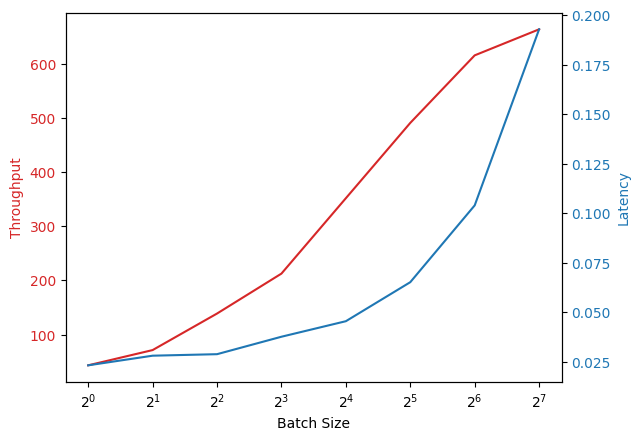

In [34]:
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "Batch Size",
    "Throughput",
    "Latency"
)

## Continuous Batching to Optimize both Throughput & Latency

In [36]:
import os, sys; sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), ".."))) if os.path.abspath(os.path.join(os.getcwd(), "..")) not in sys.path else None


In [ ]:
# Import all needed functions from Lesson 1 and 2
import helpers
from helpers import init_batch, generate_next_token
from helpers import merge_batches, filter_batch

In [ ]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [ ]:
# multiple prompts of varying lengths to send to the model at once
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

# note: padding=True ensures the padding token will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")

In [ ]:
# Batching functions
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values


def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [[] for _ in range(inputs["input_ids"].shape[0])]
    
    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)
    
    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }
    for _ in range(max_tokens):
        next_token_ids, past_key_values = generate_batch_tokens_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),  # '-1' here means the remaining elements for this dim
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,  # increment last, discard the rest
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1)),  # concatenate vector of 1's with shape [batch_size]
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

In [42]:
import random

# Demo Requests to be processed
# seed the random number generator so our results are deterministic
random.seed(42)

# constants
queue_size = 32
batch_size = 8

# requests waiting to be processed
# requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[0], 100 if i % batch_size == 0 else 10)
    for i in range(queue_size)
]

In [43]:
request_queue[:8]

[('The quick brown fox jumped over the', 100),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10)]

In [44]:
batches = [
    request_queue[i:i + batch_size]
    for i in range(0, len(request_queue), batch_size)
]

In [45]:
len(batches)

4

In [47]:
batches[0]

[('The quick brown fox jumped over the', 100),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10)]

In [51]:
# Processing Batches Sequentially (the 100 token generation request is the bottleneck)
# generate tokens for all batches and record duration
t0 = time.time()
with tqdm(total=len(batches), desc=f"bs={batch_size}") as pbar:
    for i, batch in enumerate(batches):
        # to accommodate all the requests with our 
        # current implementation, we take the max of
        # all the tokens to generate among the requests
        batch_max_tokens = [b[1] for b in batch]
        max_tokens = max(batch_max_tokens)
        pbar.set_postfix({'max_tokens': max_tokens})
        
        batch_prompts = [b[0] for b in batch]
        inputs = tokenizer(
            batch_prompts, padding=True, return_tensors="pt")
        generate_batch(inputs, max_tokens=max_tokens)
        
        pbar.update(1)

duration_s = time.time() - t0
print(f"duration: {duration_s} seconds")

bs=8: 100%|██████████| 4/4 [00:14<00:00,  3.65s/it, max_tokens=100]

duration: 14.597615003585815


In [ ]:
# Continuous Batching of Requests: 
# This time, rather than processing each batch to completion, you will use continuous batching to dynamically swap in and out inputs from the queue.

# seed the random number generator so our results are deterministic
random.seed(42)

# constants
queue_size = 32
batch_size = 8

# requests waiting to be processed
# this time requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[0], 100 if i % batch_size == 0 else 10)
    for i in range(queue_size)
]

t0 = time.time()
with tqdm(total=len(request_queue), desc=f"bs={batch_size}") as pbar:
    # first, let's seed the initial cached_batch
    # with the first `batch_size` inputs
    # and run the initial prefill step
    batch = init_batch(request_queue[:batch_size])
    cached_batch = generate_next_token(batch)
    request_queue = request_queue[batch_size:]

    # continue until both the request queue is 
    # fully drained and every input
    # within the cached_batch has completed generation
    while (
        len(request_queue) > 0 or
        cached_batch["input_ids"].size(0) > 0
    ):
        batch_capacity = (
            batch_size - cached_batch["input_ids"].size(0)
        )
        if batch_capacity > 0 and len(request_queue) > 0:
            # prefill
            new_batch = init_batch(request_queue[:batch_capacity])
            new_batch = generate_next_token(new_batch)
            request_queue = request_queue[batch_capacity:]

            # merge
            cached_batch = merge_batches(cached_batch, new_batch)

        # decode
        cached_batch = generate_next_token(cached_batch)

        # remove any inputs that have finished generation
        cached_batch, removed_indices = filter_batch(cached_batch)
        pbar.update(len(removed_indices))

duration_s = time.time() - t0
print("duration", duration_s)

bs=8: 100%|██████████| 32/32 [00:05<00:00,  6.31it/s]

duration 5.070731163024902
